# Deep Learning - Exercise 3
The aim of the lecture is to learn how to use the basic architecture based on convolutional layers and how to classify image data.

### What We'll Cover Today:
* 🎯 Convolutional Neural Networks basics
* 📊 Working with CIFAR-10 dataset
* ✅ Model validation techniques
* 🔄 Batch normalization in Keras

### Dataset Focus: CIFAR-10
* 60,000 32x32 color images
* 10 different classes
* Standard computer vision benchmark

### Core Concepts:
* Model validation importance
* Batch normalization benefits
* CNN architecture basics

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_03.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_03.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore", category=UserWarning, module='keras')
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")

In [65]:
import pandas as pd
import matplotlib.pyplot as plt  # plotting
import matplotlib.image as mpimg  # images
import numpy as np  #numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, GridSearchCV  # split for validation sets
from sklearn.preprocessing import normalize  # normalization of the matrix
from scipy.signal import convolve2d  # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix

from PIL import Image
from io import BytesIO
import time
from tqdm.notebook import trange, tqdm

tf.version.VERSION

'2.18.0'

# 📌 Defining terms for CNN

## 📒 Convolution
A convolution is defined as the integral of the product of the two functions after one is reversed and shifted. It is a mathmematical way how to analyze behavior of the functions and the relation between the functions.

In image processing, **kernel** or **convolution matrix** or **mask** is a small matrix. In general the convolution in image processing is defined as:

$$g(x, y) = \omega * f(x,y) = \sum_{s=-a}^{a}\sum_{t=-b}^{b}\omega(s,t)f(x-s, y-t)$$

where $g(x,y)$ is filtered image, $f(x,y)$ is original image, $\omega$ if the filter kernel.

A kernel (also called a filter) is a smaller-sized matrix in comparison to the dimensions of the input image, that consists of real valued entries.


![Example of the Convolution](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/convolution_example.gif?raw=true "Conv eg")

### 💡 Example filters

|Name|Definition|
|----|:--------:|
|Identity| $\left[\begin{matrix}0&0&0\\0&1&0\\0&0&0\end{matrix}\right]$|
|Sobel vertical edge detection| $\left[\begin{matrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{matrix}\right]$|
|Sobel horizontal edge detection| $\left[\begin{matrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{matrix}\right]$|
|Edge detection| $\left[\begin{matrix}-1&-1&-1\\-1&8&-1\\-1&-1&-1\end{matrix}\right]$|
|Sharpen| $\left[\begin{matrix}0&-1&0\\-1&5&-1\\0&-1&0\end{matrix}\right]$|
|Uniform blur|$\frac{1}{9}\left[\begin{matrix}1&1&1\\1&1&1\\1&1&1\end{matrix}\right]$|
|Gaussian blur 3x3| $\frac{1}{16}\left[\begin{matrix}1&2&1\\2&4&2\\1&2&1\end{matrix}\right]$|


## 📒 Padding

One tricky issue when applying convolutional is losing pixels on the edges of our image. A straightforward solution to this problem is to add extra pixels around the boundary of our input image, which increases the effective size of the image.

![Padding example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/padding_example.png?raw=true)

# 🚀 Practical example of convolution and padding without TF
* We will download the famous Lena image and try to use some filters ourselves first

#### 🤩 **Fun fact**: Have you seen the Lena image before? Do you know the story behind it? 🤩

Alexander Sawchuk estimates that it was in June or July of 1973 when he, then an assistant professor of electrical engineering at the USC Signal and Image Processing Institute (SIPI), along with a graduate student and the SIPI lab manager, was hurriedly searching the lab for a good image to scan for a colleague's conference paper. They had tired of their stock of usual test images, dull stuff dating back to television standards work in the early 1960s. They wanted something glossy to ensure good output dynamic range, and they wanted a human face. Just then, somebody happened to walk in with a recent issue of Playboy.

The engineers tore away the top third of the centerfold so they could wrap it around the drum of their Muirhead wirephoto scanner, which they had outfitted with analog-to-digital converters (one each for the red, green, and blue channels) and a Hewlett Packard 2100 minicomputer. The Muirhead had a fixed resolution of 100 lines per inch and the engineers wanted a 512 x 512 image, so they limited the scan to the top 5.12 inches of the picture, effectively cropping it at the subject's shoulders.

* See more at [2001 paper IEEE Professional Communication Society](http://www.lenna.org/pcs_mirror/may_june01.pdf)

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


lena_img_url = 'https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/lena.png?raw=true'

response = requests.get(lena_img_url)
img = Image.open(BytesIO(response.content))

## Let's see the input image first

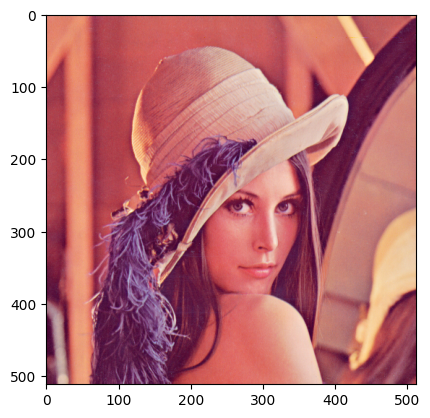

In [5]:
plt.imshow(img)

## Now let's make it grayscale
* 🔎 How many color channels did the original picture have? And how about grayscale?

In [6]:
rgb = np.array(img)
img = rgb2gray(rgb)
img = img / 255.0
img.shape

(512, 512)

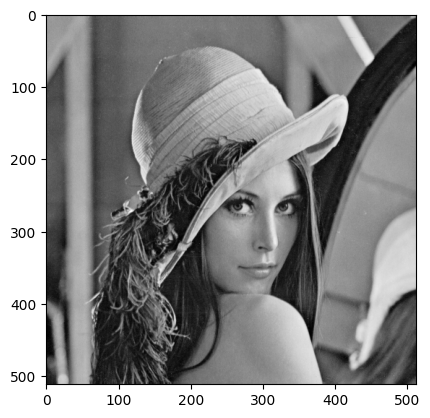

In [7]:
plt.imshow(img, cmap='gray')

## Now we can try some of the filters above

In [8]:
blur_mask = np.ones((3, 3)) / 9.0
edge_mask = np.ones((3, 3)) * -1
edge_mask[1, 1] = 8
mask = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])

## We will start with bluring the image
* 🔎 What is the effect of the blur?
    * What value does the uniform blur produce?
* 🔎 Why is blur often used in the image preprocessing?

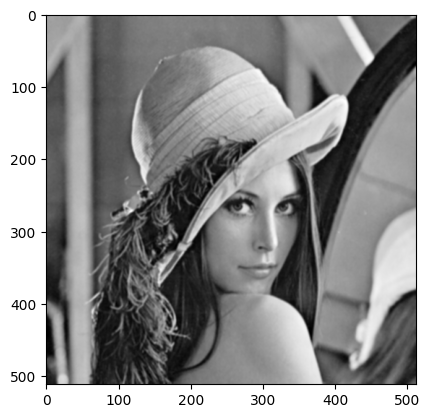

In [9]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
plt.imshow(img_blur, cmap='gray')

## Now we can apply another filter
* 🔎 Do you know what will the filter in the *edge_mask* variable do?
    * What is the effect of *np.clip()*?

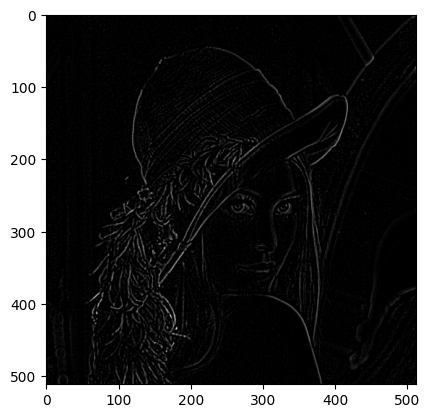

In [10]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
result = np.clip(convolve2d(img_blur, edge_mask, boundary='symm', mode='same'), 0, 1)
plt.imshow(result, cmap='gray')

## 📒 Pooling

Pooling is a way how to decrease the amount of information transfered from one layer to another.
The standard way ho to do it is Average Pooling and Maximum Pooling.

- Pooling results in (some) invariance to translation because shifting the image slightly does not change the activation map significantly. This property is referred to as translation invariance.

- The idea is that similar images often have very different relative locations of the distinctive shapes within them, and translation invariance helps in being able to classify such images in a similar way.
    - For example, one should be able to classify a bird as a bird, irrespective of where it occurs in the image.
    - Disadvantege is that you can for example succesfully classify image as face even though the position of eyes and mouth is switched, because model doesn't care about location of features in the image, their presence is for the model enough
    
- Avg. pooling is rarely used, usually we use max-pooling in the hidden layers, the only exception might be the last layer, where avg. pooling can significantly reduce the number of parameters.
- One alternative to using fully connected layers is to use average pooling across the whole spatial area of the final set of activation maps to create a single value.
    - Therefore, the number of features created in the final spatial layer will be exactly equal to the number of filters. In this scenario, if the final activation maps are of size 7 × 7 × 256, then 256 features will be created.
    - Each feature will be the result of aggregating 49 values. This type of approach greatly reduces the parameter footprint of the fully connected layers

![MaxPooling example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/pooling_example.png?raw=true)

## ⚡ Understanding Layer Dimensions

### Convolution Effects 🔍
* Input: grayscale image (depth = 1)
* Conv2D with 32 filters:
  * ⬆️ Depth increases to 32
  * ↔️ Width/height may change based on padding

### Pooling Effects 🔄
* ⬇️ Reduces spatial dimensions
  * Width ÷ pooling size
  * Height ÷ pooling size
* 🔒 Depth remains unchanged

💡 Remember:
* Conv2D → More features (depth)
* Pooling → Smaller spatial dimensions

# Tensorflow implementation of the Convolution Neural Network is quite simple

### Utility functions
There are some functions we will use later several times
* `show_history` - show history plots of the **fit** method

* `show_example` - show 10x10 image grid with input image examples

* `display_activation` - CNN produces matrices as an each layer output, we can take a look at the output of the layers using this function


In [11]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()


def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()


def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3] - 1:
                activation_index += 1

## Load dataset
Import dataset **CIFAR10**
* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.
* The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.
* There are 6,000 images of each class.

Dataset is then:
* splitted into train and test set,
* converted from the range <0,255> into <0, 1>,
* *train* is splitted into *train* and *validation* set,
* class names are defined.

In [12]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x / 255.0
test_x = test_x / 255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)
print('Class count:', class_count, class_names)


Train data shape:  (40000, 32, 32, 3) (40000, 1)
Validation data shape:  (10000, 32, 32, 3) (10000, 1)
Test data shape:   (10000, 32, 32, 3) (10000, 1)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## We will start with checking example images of the dataset first

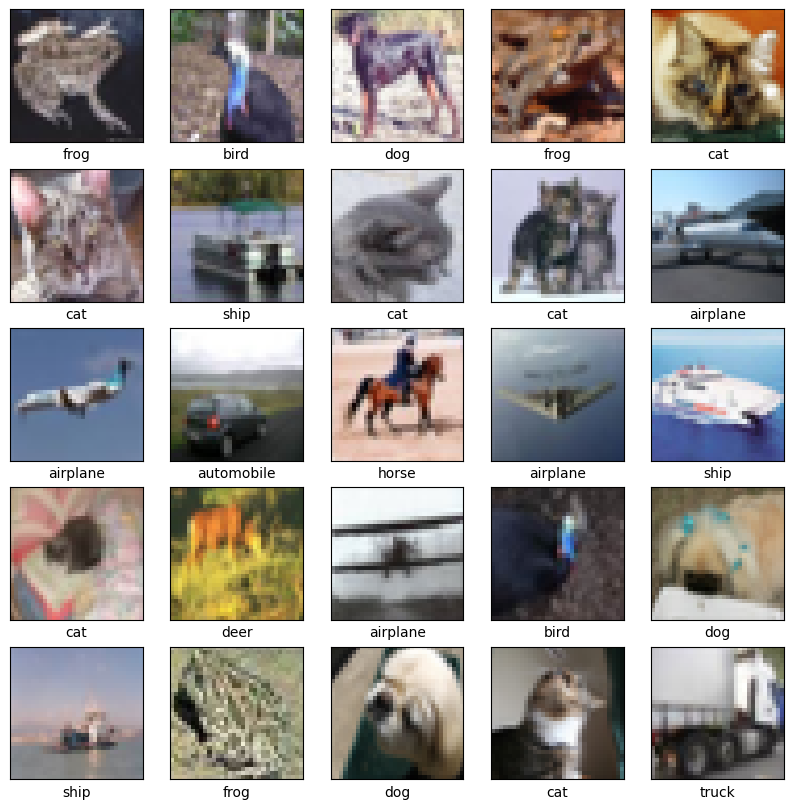

In [13]:
show_example(train_x, train_y, class_names)

# 🚀 Definition of the model
* The base model is defined as *Sequential* with just 2 convolutional layers.
* We will start with very simple model first, but we will make the model better later!

### Conv2D Layer Parameters 🔧
* filters: number of kernels
* kernel_size: filter dimensions
* activation: activation function
* padding: `valid` or `same`
* input_shape: for first layer only

### Dimension Questions ❓

1. For (32,32,3) input + `Conv2D(32)`:
   * Output depth = 32 (filter count)
   * WxH depends on padding
   * 'same' padding preserves dimensions

2. After `MaxPool2D(2,2)`:
   * Depth stays 32
   * Width ÷ 2
   * Height ÷ 2

### Why These Choices? 🤔
* Softmax: ❓
    * Converts logits to probabilities for multi-class classification.
* Accuracy: ❓
    *  Measures the proportion of correctly classified instances.


In [14]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

I0000 00:00:1741288506.555664   19292 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,290 (700.35 KB)

 Trainable params: 179,290 (700.35 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the model for defined number of epochs.
Show the history of learning, evaluate the efficiency of the model.

* 🔎 Did we overfit the model? What can we do about it if so?
     *  compare the training accuracy and validation accuracy
          * Add dropout layers.
          * Use data augmentation.
          * Reduce the complexity of the model.
          * Use regularization techniques like L2 regularization.

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10


I0000 00:00:1741288509.137060   19362 service.cc:148] XLA service 0x7f80a400a980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741288509.137094   19362 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
I0000 00:00:1741288509.286355   19362 cuda_dnn.cc:529] Loaded cuDNN version 90501


  54/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1026 - loss: 2.3009

I0000 00:00:1741288510.427281   19362 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3469 - loss: 1.7817 - val_accuracy: 0.5254 - val_loss: 1.3284
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5444 - loss: 1.2804 - val_accuracy: 0.5827 - val_loss: 1.1886
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5980 - loss: 1.1393 - val_accuracy: 0.5954 - val_loss: 1.1638
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6248 - loss: 1.0543 - val_accuracy: 0.6145 - val_loss: 1.1060
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6526 - loss: 0.9889 - val_accuracy: 0.6141 - val_loss: 1.0887
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6708 - loss: 0.9398 - val_accuracy: 0.6229 - val_loss: 1.0741
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6888 - loss: 0.8849 - val_accuracy: 0.6259 - val_loss: 1.0625
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7049 - loss: 0.8392 - val_accurac

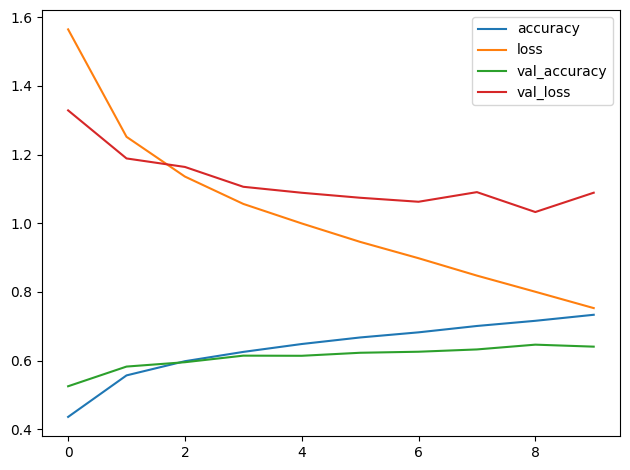

In [16]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback],
                    batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc_fashion = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc_fashion)

# 📊 Vizualization of the confusion matrix
* By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$
    * 🔎 How can we read such matrix?
        * Each row represents the actual class.
        * Each column represents the predicted class.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


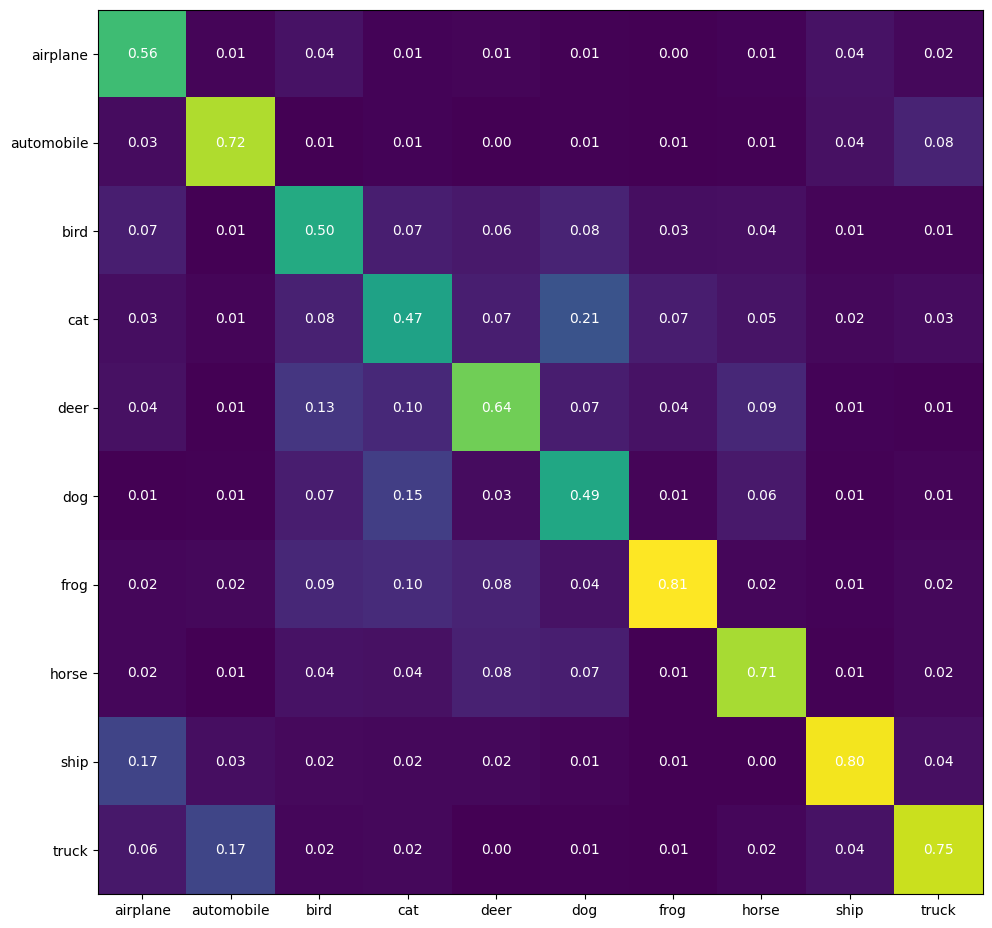

In [17]:
predictions = model.predict(test_x)

conf_matrix = confusion_matrix(np.argmax(predictions, axis=1), test_y.ravel(), normalize='pred')
plt.figure(figsize=(class_count, class_count))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.xticks(range(class_count), class_names)
plt.yticks(range(class_count), class_names)

plt.tight_layout()
plt.show()

# Visualize the layers
* Let's see what the network was able to learn from the train data.
* For that, we need to prepare a new model and see the ouputs of the layers.

In [18]:
# Call the model with some input data to define the input shape
_ = model.predict(train_x[:1])

# Get the outputs form all layers in the model
layer_outputs = [layer.output for layer in model.layers]

# Create the model that has single input and as an output all the outputs from the layers.
# Because the layers are connected then the output from first layer is propagated into second layer and the output is computed of it.
activation_model = keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


In [19]:
layer_outputs

[<KerasTensor shape=(None, 30, 30, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 15, 15, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 13, 13, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 2704), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>]

In [20]:
# get all the outputs from the model for 10-th input
activations = activation_model.predict(train_x[10].reshape((1, 32, 32, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


In [21]:
layer_outputs

[<KerasTensor shape=(None, 30, 30, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 15, 15, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 13, 13, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 2704), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>]

## Input image

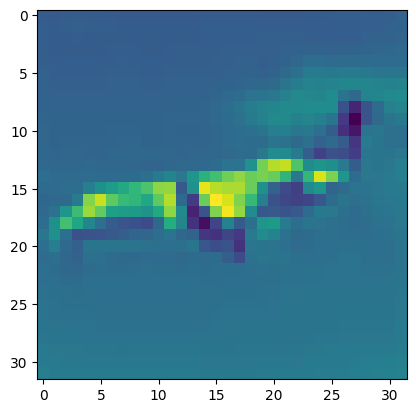

In [22]:
plt.imshow(train_x[10][:, :, 0]);

## 🔎 Can you describe purpose of some layers based on the output?

We got some edges and shades, shapes etc.

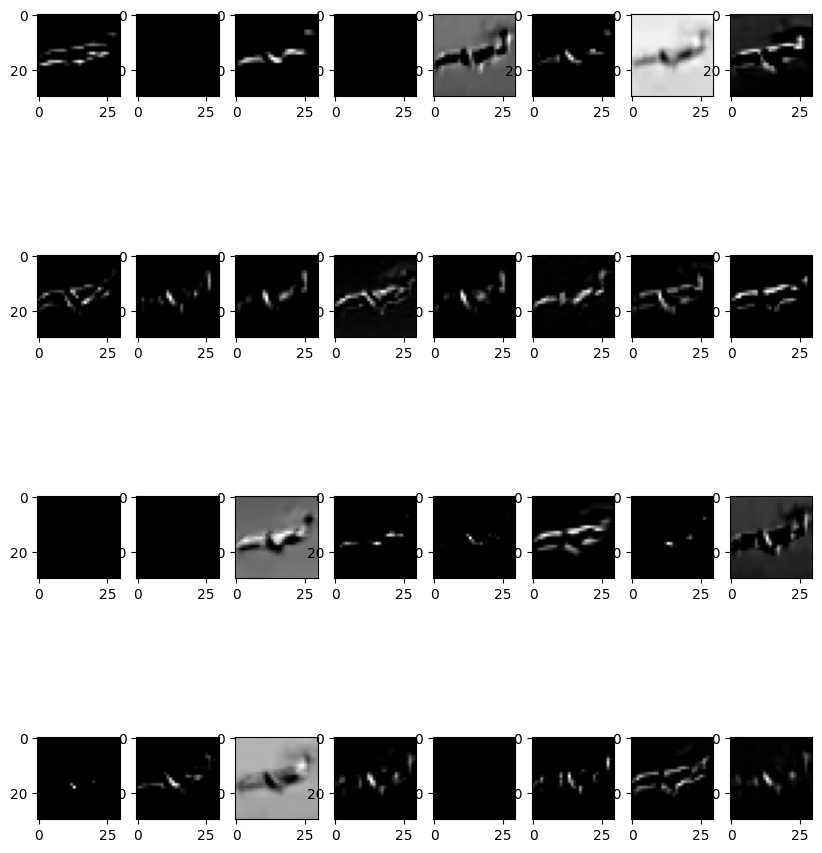

In [23]:
# show the output from the first layer - Conv2D
display_activation(activations, 8, 4, 0)

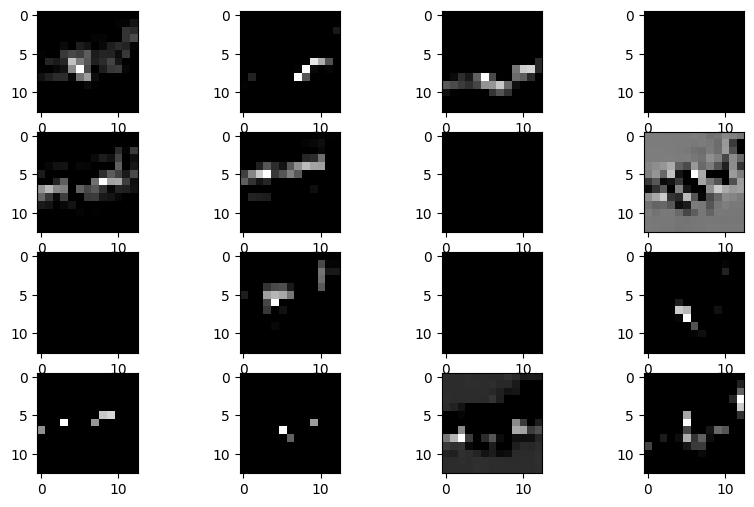

In [24]:
# show the second convolution layer
display_activation(activations, 4, 4, 2)

## 💡 You can see that the ANN just automated the manual image filter composition for the feature extraction used by traditional computer vision approaches

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_02_meme.png?raw=true)

# 🔎 How to make ANN better?
* We can make out ANN better by architecture design changes or we can focus on detailts of the architecture such as activation functions or adding some helpful layers
    * e.g. Dropout, Batch. norm, ...

## 📒 Batch normalization
- If we have some two input variables with scales from 0 to 1 and from 0 to 1000 we can normalize them
    - Larger scale does not mean that the varible is more important than the other one
    - It's clear that without normalization one weight will be very high and other very low to balance the scale difference
    - This leads to slow gradient descent convergence - we need small learning rates
        - Loss function space is not smooth - gradients may oscillate back and forth before finding optimum
        
- This issue is present in hidden layers as well due to the mini-batch learning
    - Each batch is different from others from distributions point of view
    - Covariate shift effect - distribution of data is constantly changing during training
        - E.g. We train model on images of black cats - we learn how to map input X to output Y
        - If we now use images of colored cats for testing purposes the model will fail - input X changed thus learned mapping is invalid
        - This shift happens internally with mini-batches all the time
        
- 📌 **Batch norm. standardize activation values to have same mean and variance among batch**
    - Slight regularization - it adds some noise to each hidden layer’s activations so less overfitting
    - We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low
    - It makes the landscape of the corresponding optimization problem be significantly more smooth. This ensures, in particular, that the gradients are more predictive and thus allow for use of larger range of learning rates and faster network convergence
    
- 💡 Keras: tf.keras.layers.BatchNormalization
    - https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    - Usually after Conv or Dense layers
    - There are of course multiple different approaches where the batch norm. can be placed

## 📒 Activation function choice
* We can use any activation function we want, very common choice is ReLU or Leaky ReLU
* Another very popular activation function nowadays is **Mish (Self Regularized Non-Monotonic Activation Function)**
* It's not only one, there are more Swish etc.

* 🚀 Definitely checkout [Mish repo](https://github.com/digantamisra98/Mish)

In [25]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))


get_custom_objects().update({'mish': Mish(mish)})

# ⚡ We can modify our network to use such tweaks very easily

### Activation Update 📈
* Replace ReLU with Mish
  * Smoother gradients
  * Better performance

### Overfitting Solutions 🛡️
* Add Dropout layers
* Use BatchNormalization
* Increase regularization
* Reduce model capacity

In [26]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='mish'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='mish'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,290 (700.35 KB)

 Trainable params: 179,290 (700.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3445 - loss: 1.8057 - val_accuracy: 0.5322 - val_loss: 1.3267
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5294 - loss: 1.3380 - val_accuracy: 0.5780 - val_loss: 1.2093
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5822 - loss: 1.1781 - val_accuracy: 0.6044 - val_loss: 1.1476
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6128 - loss: 1.0964 - val_accuracy: 0.6334 - val_loss: 1.0614
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6440 - loss: 1.0116 - val_accuracy: 0.6395 - val_loss: 1.0324
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6655 - loss: 0.9489 - val_accuracy: 0.6424 - val_loss: 1.0322
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6841 - loss: 0.8935 - val_accuracy: 0.6494 - val_loss: 1.0270
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6966 - loss: 0.8435 - 

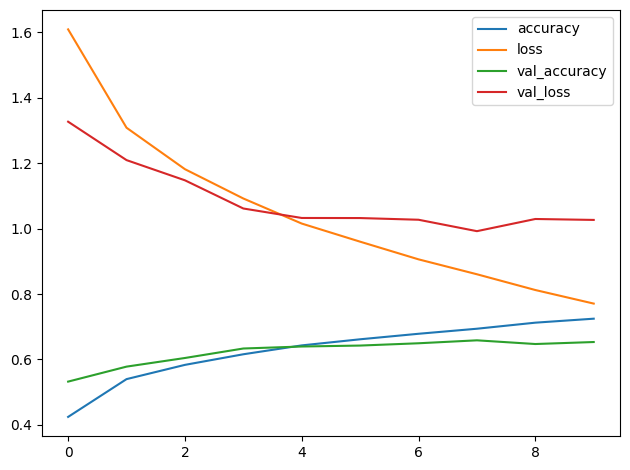

In [27]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback],
                    batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc_fashion = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc_fashion)

## 🔎 Is the model better? What about the overfit?

Check validation accuracy vs. training accuracy. If validation accuracy is lower, the model might be overfitting.

## 🚀 Now we will add Batch normalization as well and try slight layer order change
* What will happen if we stack 2x Conv2D layers?
    * Stacking 2x Conv2D layers can capture more complex features with no benefot whatsoever.
* 🔎 Do we have more or less parameters than in the previous case?
    * More parameters due to additional Conv2D layer.

In [28]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(16, (3, 3), activation='mish'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,130 (809.10 KB)

 Trainable params: 207,034 (808.73 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3544 - loss: 1.8736 - val_accuracy: 0.4897 - val_loss: 1.4015
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5406 - loss: 1.2891 - val_accuracy: 0.5733 - val_loss: 1.2237
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6079 - loss: 1.1069 - val_accuracy: 0.6295 - val_loss: 1.0622
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6452 - loss: 1.0190 - val_accuracy: 0.6404 - val_loss: 1.0285
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6701 - loss: 0.9256 - val_accuracy: 0.6550 - val_loss: 0.9896
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6889 - loss: 0.8826 - val_accuracy: 0.6730 - val_loss: 0.9595
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7052 - loss: 0.8371 - val_accuracy: 0.6758 - val_loss: 0.9549
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7189 - loss: 0.7938 -

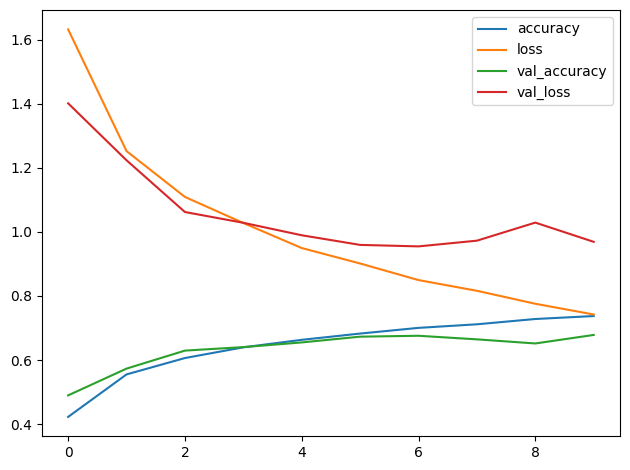

In [29]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback],
                    batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc_fashion = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc_fashion)

![Data aug example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/data_aug.png?raw=true)

## 📌 ANN models need huge amount of data as an input to function properly
### 💡 Data augmentation is very popular technique for the image data as it can help enlarge the dataset and harden the model for abnormal conditions

* ❌ There might be bug present in the TF2, so beware the label encoding
    * I had the same issue even few years ago, so I guess that today it's not a bug but a feature 😅
* 💡 We need to one-hot encode the labels and change the loss function to the CategoricalCrossentropy
    * Note that the output activation function is now set to softmax
    * Take a look at [this](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [30]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

train_y = tf.keras.utils.to_categorical(train_y, class_count)
test_y = tf.keras.utils.to_categorical(test_y, class_count)

train_x = train_x / 255.0
test_x = test_x / 255.0

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)
print('Class count:', class_count, class_names)


Train data shape:  (50000, 32, 32, 3) (50000, 10)
Test data shape:   (10000, 32, 32, 3) (10000, 10)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 📒 ImageDataGenerator provides variety of modifications
* 💡 You need to decide based on **the input data and task** that you try to solve which of the image modifications can be used given the real data obtained 💡
    * 📸 Imagine that you are designing a model for a **car detection used by the entry gate camera system** at the university parking lot entrance
        * Your training dataset is made of images of cars, will the vertical flip (i.e. cars turned on the roof) of the images make any sense for your task?
    * 🚒 And what if the task is **traffic accident detection** in front of the car for autonomous driving system?
        * Can vertical flip help you now? 😊

In [31]:
datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
    #     rotation_range=20,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(train_x)

epochs = 20

model = keras.Sequential([
    keras.layers.Conv2D(128, (5, 5), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation='mish', padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3, 3), activation='mish'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 710,986 (2.71 MB)

 Trainable params: 710,986 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3440 - loss: 1.8114 - val_accuracy: 0.4840 - val_loss: 1.4611
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5115 - loss: 1.3813 - val_accuracy: 0.5884 - val_loss: 1.1689
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5825 - loss: 1.1809 - val_accuracy: 0.6122 - val_loss: 1.0905
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6292 - loss: 1.0717 - val_accuracy: 0.6346 - val_loss: 1.0319
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6511 - loss: 0.9851 - val_accuracy: 0.6522 - val_loss: 0.9908
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6898 - loss: 0.8906 - val_accuracy: 0.6751 - val_loss: 0.9456
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7117 - loss: 0.8211 - val_accuracy: 0.6914 - val_loss: 0.9271
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7354 - loss: 0.7513 -

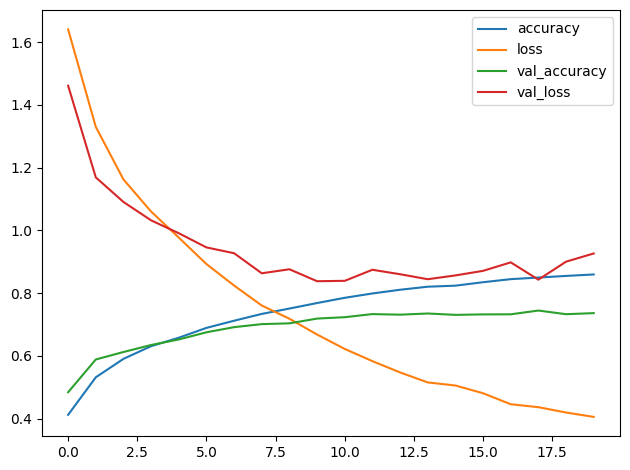

In [32]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(datagen.flow(train_x, train_y, batch_size=32,
                                 subset='training'), validation_data=datagen.flow(train_x, train_y,
                                                                                  batch_size=32, subset='validation'),
                    epochs=epochs)
show_history(history)

In [33]:
test_loss, test_acc_fashion = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc_fashion)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7311 - loss: 0.9459
Test accuracy:  0.73089998960495


## 🚀 What if we have large datasets and we are not able to fit it into the memory?
* 💡 A very simple solution is to transform the dataset into the specific folder structure and use [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
    * We can leverage `tf.keras.preprocessing.image_dataset_from_directory` method for loading
* Let's try it with MNIST dataset

In [34]:
DATASET_NAME = 'mnist'
OUTPUT_DIR = '../datasets/mnist_data'  # Directory to save the MNIST images
TRAIN_DIR = os.path.join(OUTPUT_DIR, 'train')
TEST_DIR = os.path.join(OUTPUT_DIR, 'test')

# Create the output directories if they don't exist
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [36]:
def save_images(images, labels, directory, split_name):
    """Saves images from NumPy arrays to disk in a directory structure.

    Args:
        images: A NumPy array of images.
        labels: A NumPy array of corresponding labels.
        directory: The base directory to save the images to.
        split_name: "train" or "test", used for subdirectory creation.
    """

    split_dir = os.path.join(directory, split_name)  # e.g., mnist_data/train
    os.makedirs(split_dir, exist_ok=True)

    for i, (image, label) in tqdm(enumerate(zip(images, labels)), total=len(images)):
        label_dir = os.path.join(split_dir, str(label))  # e.g., mnist_data/train/5
        os.makedirs(label_dir, exist_ok=True)

        image = Image.fromarray(image)  # Convert NumPy array to PIL Image
        image_path = os.path.join(label_dir, f'{i:05d}.png')  # e.g., mnist_data/train/5/00001.png
        image.save(image_path)

    print(f"Finished saving {split_name} split.")

## Save the dataset in the directory

In [37]:
save_images(x_train, y_train, OUTPUT_DIR, 'train')
save_images(x_test, y_test, OUTPUT_DIR, 'test')

print("MNIST dataset saved to:", OUTPUT_DIR)

  0%|          | 0/60000 [00:00<?, ?it/s]

Finished saving train split.


  0%|          | 0/10000 [00:00<?, ?it/s]

Finished saving test split.
MNIST dataset saved to: ../datasets/mnist_data


## 🚀 Now we can load the dataset from the directory as a datastream

In [38]:
IMG_WIDTH, IMG_HEIGHT = 32, 32  # Adjust to the image size
BATCH_SIZE = 32

In [39]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',  # Assumes labels are based on directory structure
    label_mode='categorical',  # One-hot encode the labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the training data will be used for validation
    subset='training',  # This specifies that this is the training split
    seed=13  # For reproducibility
)

Found 60000 files belonging to 10 classes.
Using 48000 files for training.


In [40]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,  # Use the same training directory for validation data
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',  # This specifies that this is the validation split
    seed=13
)

Found 60000 files belonging to 10 classes.
Using 12000 files for validation.


In [41]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


## Configure Dataset for higher performance
* `tf.data.AUTOTUNE` will dynamically determine the optimal buffer size at runtime, which can help improve the efficiency of data loading

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## ⚡ Build the CNN Model

In [43]:
num_classes = 10

model = keras.Sequential([
    keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    keras.layers.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),  # Normalize pixel values
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

## 🚀 Finally, we will train the model and evaluate the performance

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.9150 - loss: 0.2744 - val_accuracy: 0.9830 - val_loss: 0.0566
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9855 - val_loss: 0.0501
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9899 - loss: 0.0308 - val_accuracy: 0.9872 - val_loss: 0.0426
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.9883 - val_loss: 0.0436
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9946 - loss: 0.0169 - val_accuracy: 0.9859 - val_loss: 0.0633
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9954 - loss: 0.0142 - val_accuracy: 0.9875 - val_loss: 0.0612
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9956 - loss: 0.0125 - val_accuracy: 0.9878 - val_loss: 0.0546
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9966 - loss: 0.0106 

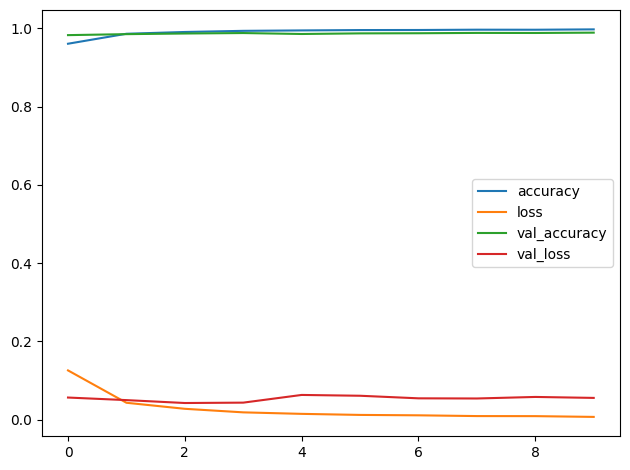

In [45]:
history = model.fit(train_dataset, validation_data=validation_dataset, callbacks=[model_checkpoint_callback], epochs=10)
show_history(history)

## 📊 Calculate the accuracy using the test data

In [46]:
model.load_weights("best.weights.h5")
test_loss, test_acc_fashion = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc_fashion)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9867 - loss: 0.0418
Test accuracy:  0.9883999824523926


# ✅  Tasks for the lecture (2p)
<!-- 1. [Data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) is used to expand the training dataset in order to improve the performance and ability of the model to generalize.
    - [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) -->
    
1) Design a model which will be able to classify **CIFAR10** with accuracy higher than **80% - (1p)**

    - 💡 Definitely train your model with more epochs than 10 (you can try 20 to 50 for example)

    - 💡 I recommend experimenting with the batch sizes, lower the batch size if the training is not stable (high variance in the loss function values) or higher the number if the training is too slow
    
2) Try to work with MNIST and FashionMnist datasets as an image - **(1p)**

    - 99% on **Mnist** is achievable using CNN
    
    - 94% on **Fashion-Mnist**  (https://keras.io/api/datasets/fashion_mnist/) too

# Tasks

### Time helper tracking (for fun)

In [47]:
class TimeTracker:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time
        minutes = self.execution_time // 60
        seconds = self.execution_time % 60
        print(f"Execution time: {minutes:.0f} minutes and {seconds:.2f} seconds")

## Task 1

### Load CIFAR-10 dataset and normalize data

In [48]:
((train_images, train_labels),
 (test_images, test_labels)) = tf.keras.datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

### Define the same model as in the notebook and data augmentation

In [49]:
def create_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [50]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

In [51]:
def train_model(epochs, batch_size):
    model = create_model()
    with TimeTracker():
        history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(test_images, test_labels))
    return history

### 🚀 Let's find the best batch size 📊

In [52]:
batch_sizes = [32, 64, 128]
best_batch_size = None
best_accuracy = 0
best_loss = float('inf')
histories = []

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    history = train_model(10, batch_size)
    histories.append((batch_size, history))
    val_accuracy = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])
    if val_accuracy > best_accuracy or (val_accuracy == best_accuracy and val_loss < best_loss):
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_batch_size = batch_size

print(f"Best batch size: {best_batch_size} with accuracy: {best_accuracy} and loss: {best_loss}")

Training with batch size: 32
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.2747 - loss: 1.9263 - val_accuracy: 0.5029 - val_loss: 1.3754
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4807 - loss: 1.4485 - val_accuracy: 0.5772 - val_loss: 1.1839
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5286 - loss: 1.3156 - val_accuracy: 0.6079 - val_loss: 1.0991
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5667 - loss: 1.2394 - val_accuracy: 0.6299 - val_loss: 1.0462
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5898 - loss: 1.1684 - val_accuracy: 0.6407 - val_loss: 1.0360
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6130 - loss: 1.1121 - val_accuracy: 0.6743 - val_loss: 0.9117
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6249 - loss: 1.0705 - val_accuracy: 0.6689 - val_loss: 0.9538
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 1

In [53]:
def plot_all_batch_sizes(histories):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Create 1 row, 2 columns

    for batch_size, history in histories:
        axes[0].plot(history.history['accuracy'], label=f'Batch Size {batch_size}')
    axes[0].set_title('Training Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    for batch_size, history in histories:
        axes[1].plot(history.history['val_accuracy'], label=f'Batch Size {batch_size}')
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Plot all batch sizes 📈

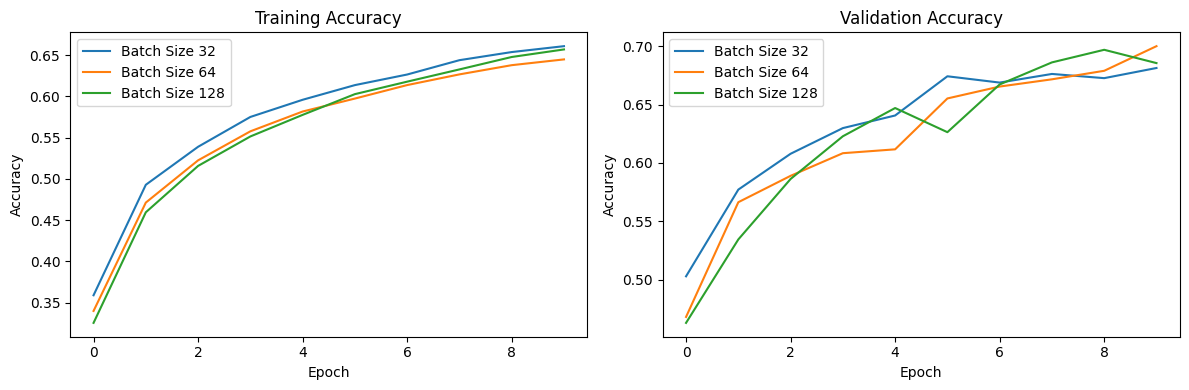

In [54]:
plot_all_batch_sizes(histories)

### ⏳ Train the model for different epochs and save the histories

In [55]:
history_25 = train_model(25, best_batch_size)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.2470 - loss: 1.9785 - val_accuracy: 0.4879 - val_loss: 1.4080
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4502 - loss: 1.5154 - val_accuracy: 0.5453 - val_loss: 1.2556
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5062 - loss: 1.3843 - val_accuracy: 0.5849 - val_loss: 1.1459
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5431 - loss: 1.2921 - val_accuracy: 0.6139 - val_loss: 1.0662
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5638 - loss: 1.2308 - val_accuracy: 0.6208 - val_loss: 1.0494
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5850 - loss: 1.1806 - val_accuracy: 0.6505 - val_loss: 0.9883
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6048 - loss: 1.1258 - val_accuracy: 0.6562 - val_loss: 0.9622
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6187 - loss: 1.0959 - 

In [56]:
history_50 = train_model(50, best_batch_size)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.2497 - loss: 1.9919 - val_accuracy: 0.4871 - val_loss: 1.4244
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4460 - loss: 1.5208 - val_accuracy: 0.5454 - val_loss: 1.2630
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5037 - loss: 1.3794 - val_accuracy: 0.5976 - val_loss: 1.1384
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5414 - loss: 1.2893 - val_accuracy: 0.6002 - val_loss: 1.1376
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5658 - loss: 1.2278 - val_accuracy: 0.6290 - val_loss: 1.0626
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5888 - loss: 1.1678 - val_accuracy: 0.6403 - val_loss: 1.0020
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6069 - loss: 1.1237 - val_accuracy: 0.6384 - val_loss: 1.0473
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6240 - loss: 1.0750 - 

In [57]:
history_75 = train_model(75, best_batch_size)

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.2623 - loss: 1.9704 - val_accuracy: 0.4824 - val_loss: 1.4065
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4579 - loss: 1.5039 - val_accuracy: 0.5405 - val_loss: 1.2724
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5159 - loss: 1.3489 - val_accuracy: 0.5819 - val_loss: 1.1712
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5453 - loss: 1.2816 - val_accuracy: 0.6293 - val_loss: 1.0412
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5785 - loss: 1.1957 - val_accuracy: 0.6227 - val_loss: 1.0650
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5959 - loss: 1.1498 - val_accuracy: 0.6551 - val_loss: 0.9726
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6064 - loss: 1.1154 - val_accuracy: 0.6739 - val_loss: 0.9599
Epoch 8/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6236 - loss: 1.0700 - 

In [58]:
history_100 = train_model(100, best_batch_size)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.2542 - loss: 1.9801 - val_accuracy: 0.4661 - val_loss: 1.4410
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4502 - loss: 1.5155 - val_accuracy: 0.5597 - val_loss: 1.2271
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5128 - loss: 1.3682 - val_accuracy: 0.5921 - val_loss: 1.1272
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5457 - loss: 1.2785 - val_accuracy: 0.6318 - val_loss: 1.0293
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5758 - loss: 1.2151 - val_accuracy: 0.6142 - val_loss: 1.0969
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5946 - loss: 1.1689 - val_accuracy: 0.6584 - val_loss: 0.9792
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6125 - loss: 1.1069 - val_accuracy: 0.6754 - val_loss: 0.9324
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6319 - loss: 1

### Different epoch plotting 📈

In [59]:
def plot_history(histories, epochs):
    plt.figure(figsize=(12, 8))

    for i, history in enumerate(histories):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Epochs: {epochs[i]}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

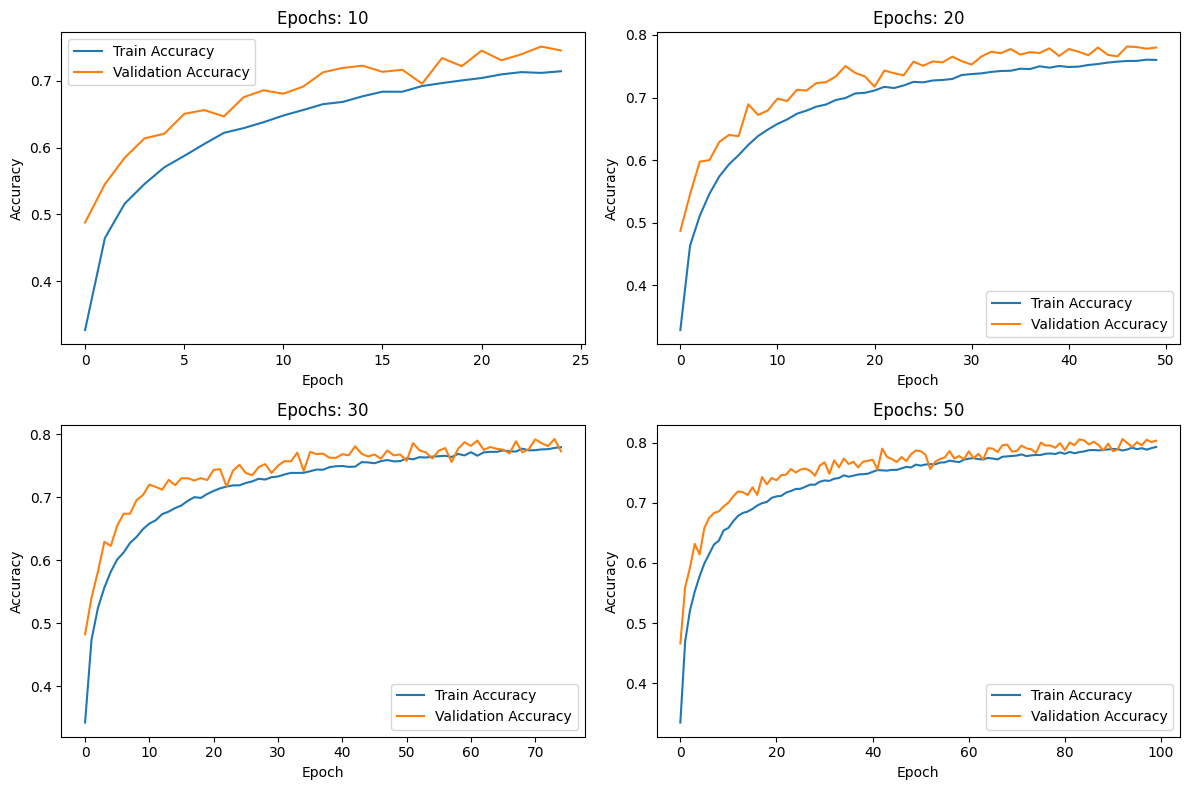

In [60]:
plot_history([history_25, history_50, history_75, history_100], [10, 20, 30, 50])

In [74]:
histories = [history_25, history_50, history_75, history_100]
all_histories_df = pd.DataFrame()

for i, history in enumerate(histories):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['model'] = f'model_{i * 25 + 25}'
    all_histories_df = pd.concat([all_histories_df, history_df], ignore_index=True)

In [75]:
last_results = all_histories_df.groupby('model').tail(1)
last_results

,accuracy,loss,val_accuracy,val_loss,epoch,model
24,0.71426,0.833976,0.7454,0.743143,24,model_25
74,0.76018,0.701550,0.7800,0.659147,49,model_50
149,0.77972,0.647722,0.7732,0.695108,74,model_75
249,0.79310,0.609353,0.8036,0.597283,99,model_100


## Task 2

### Mnist

#### Load MNIST dataset and preprocess data

In [138]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

In [139]:
mnist_train_images, mnist_test_images = mnist_train_images / 255.0, mnist_test_images / 255.0

In [140]:
mnist_train_images = mnist_train_images.reshape((mnist_train_images.shape[0], 28, 28, 1))
mnist_test_images = mnist_test_images.reshape((mnist_test_images.shape[0], 28, 28, 1))

#### 🏗️ Architecture
1. **👁 Input:** `(28,28,1)`
   - Grayscale image input (28x28 pixels).
2. **🧠 Conv Block 1:**
   - `Conv2D(32, 5x5) → ReLU → Conv2D(32, 5x5) → ReLU`
   - **Captures basic features (edges, patterns).**
   - `MaxPool(2x2) → Dropout(0.25)`
   - **Reduces dimensions, prevents overfitting.**
3. **🧠 Conv Block 2:**
   - `Conv2D(64, 3x3) → ReLU → Conv2D(64, 3x3) → ReLU`
   - **Extracts more complex features.**
   - `MaxPool(2x2) → Dropout(0.25)`
   - **Further downsampling and regularization.**
4. **🔄 Fully Connected:**
   - `Flatten → Dense(256) → ReLU → Dropout(0.25)`
   - **Final feature extraction before classification.**
5. **🎯 Output:** `Dense(10, softmax)`
   - **Predicts probabilities for 10 digit classes.**

### ⚡ Features
- ✔ **Efficiency:** Two conv blocks with pooling.
- ✔ **Dropout (0.25):** Prevents overfitting at multiple stages.
- ✔ **Softmax Activation:** Outputs class probabilities.


In [141]:
mnist_model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='softmax'),
])

mnist_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 20, 20, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,170 (906.91 KB)

 Trainable params: 232,170 (906.91 KB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [142]:
mnist_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    optimizer='adam',
                    metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [143]:
history_mnist = mnist_model.fit(mnist_train_images, mnist_train_labels,
                                validation_split=0.2,
                                epochs=25,
                                callbacks=[model_checkpoint_callback],
                                batch_size=best_batch_size)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8375 - loss: 0.4978 - val_accuracy: 0.9795 - val_loss: 0.0618
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9759 - loss: 0.0762 - val_accuracy: 0.9878 - val_loss: 0.0440
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9839 - loss: 0.0496 - val_accuracy: 0.9901 - val_loss: 0.0316
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9868 - loss: 0.0418 - val_accuracy: 0.9909 - val_loss: 0.0309
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9886 - loss: 0.0370 - val_accuracy: 0.9915 - val_loss: 0.0296
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9902 - loss: 0.0331 - val_accuracy: 0.9900 - val_loss: 0.0363
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9899 - loss: 0.0315 - val_accuracy: 0.9922 - val_loss: 0.0291
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9913 - loss: 0.0270 - val_accuracy: 0.

In [144]:
mnist_model.load_weights("best.weights.h5")

#### Results

In [145]:
test_loss_mnist, test_acc_mnist = mnist_model.evaluate(mnist_test_images, mnist_test_labels)
print('Test accuracy:', test_acc_mnist)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0308
Test accuracy: 0.9933000206947327


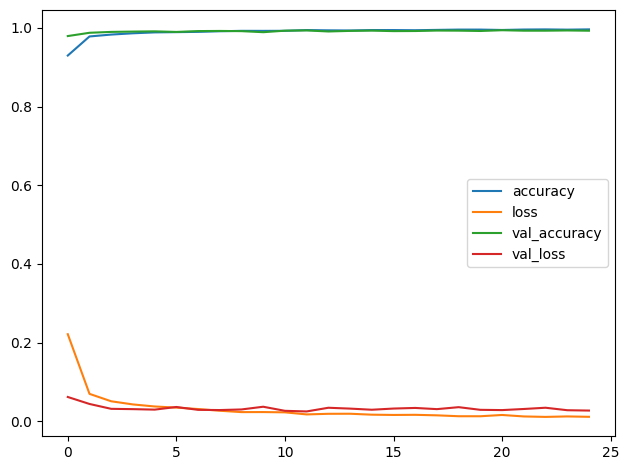

In [146]:
show_history(history_mnist)

### Mnist-Fashion

#### Load Fashion-MNIST dataset and preprocess it

In [147]:
((fashion_train_images, fashion_train_labels),
 (fashion_test_images, fashion_test_labels)) = tf.keras.datasets.fashion_mnist.load_data()

In [148]:
fashion_train_images, fashion_test_images = fashion_train_images / 255.0, fashion_test_images / 255.0

In [149]:
fashion_train_images = fashion_train_images.reshape((fashion_train_images.shape[0], 28, 28, 1))
fashion_test_images = fashion_test_images.reshape((fashion_test_images.shape[0], 28, 28, 1))

#### 🏗️ Architecture
1. **👁 Input:** `(28,28,1)`
   - Grayscale image input (28x28 pixels, 1 channel).
2. **🧠 Conv Block 1:**
   - `Conv2D(32) → BN → ReLU → Conv2D(32) → BN → ReLU`
   - **Extracts low-level features** (edges, textures).
   - `MaxPool(2x2) → Dropout(0.3)`
   - **Reduces spatial size**, prevents overfitting.
3. **🧠 Conv Block 2:**
   - `Conv2D(64) → BN → ReLU → Conv2D(64) → BN → ReLU`
   - **Extracts higher-level patterns** (shapes, structures).
   - `MaxPool(2x2) → Dropout(0.4)`
   - Further **downsamples features**, avoids overfitting.
4. **🔄 Fully Connected:**
   - `Flatten → Dense(256) → BN → ReLU → Dropout(0.5)`
   - **Transforms features into a classification-ready format.**
5. **🎯 Output:** `Dense(10, softmax)`
   - **Predicts probabilities for 10 clothing categories.**

### ⚡ Features
- ✔ **Efficiency:** Two convolutional blocks for feature extraction.
✔ **Batch Normalization:** Stability and convergence.
✔ **Dropout Regularization:** 🛑 overfitting at different stages.
✔ **Softmax Activation:** Outputs class probabilities.

In [150]:
fashion_mnist_model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax'),
])

fashion_mnist_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,426 (3.33 MB)

 Trainable params: 871,530 (3.32 MB)

 Non-trainable params: 896 (3.50 KB)

#### Train the model

In [151]:
fashion_mnist_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [152]:
history_fashion_mnist = fashion_mnist_model.fit(
    fashion_train_images,
    fashion_train_labels,
    validation_data=(fashion_test_images, fashion_test_labels),
    epochs=25,
    callbacks=[model_checkpoint_callback],
    batch_size=best_batch_size
)

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7719 - loss: 0.6875 - val_accuracy: 0.8875 - val_loss: 0.3128
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8822 - loss: 0.3243 - val_accuracy: 0.9019 - val_loss: 0.2710
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8984 - loss: 0.2784 - val_accuracy: 0.8985 - val_loss: 0.2837
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9072 - loss: 0.2512 - val_accuracy: 0.9099 - val_loss: 0.2462
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9170 - loss: 0.2312 - val_accuracy: 0.9200 - val_loss: 0.2178
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9194 - loss: 0.2219 - val_accuracy: 0.9201 - val_loss: 0.2205
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9229 - loss: 0.2142 - val_accuracy: 0.9230 - val_loss: 0.2094
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9274 - loss: 0.1984 - val_accuracy:

In [153]:
fashion_mnist_model.load_weights("best.weights.h5")

#### Results

In [154]:
test_loss_fashion, test_acc_fashion = fashion_mnist_model.evaluate(fashion_test_images, fashion_test_labels)
print('Test accuracy:', test_acc_fashion)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9403 - loss: 0.1783
Test accuracy: 0.9406999945640564


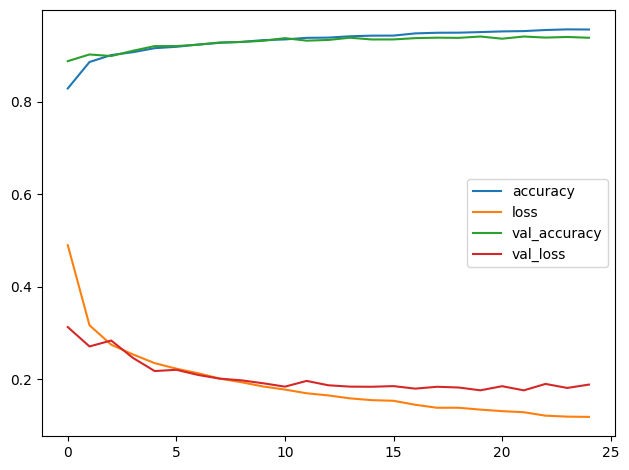

In [155]:
show_history(history_fashion_mnist)